# Explore here

In [17]:
# Sistema de predicción de ventas
# Establecer el almacén de nuestra empresa en otra localización y estimar el ritmo de las ventas para los próximos meses, a fin de proveer el espacio que necesitaremos.

# Cargar conjunto de datos
import pandas as pd

total_data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv")

total_data.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [18]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [19]:
# Los datos de la fecha son string, hay que pasarlos a numérico (formato Datetime)
total_data["date"] = pd.to_datetime(total_data.date)
total_data = total_data.set_index("date")
ts_total = total_data["sales"]
ts_total.head()

date
2022-09-03 17:10:08.079328    55.292157
2022-09-04 17:10:08.079328    53.803211
2022-09-05 17:10:08.079328    58.141693
2022-09-06 17:10:08.079328    64.530899
2022-09-07 17:10:08.079328    66.013633
Name: sales, dtype: float64

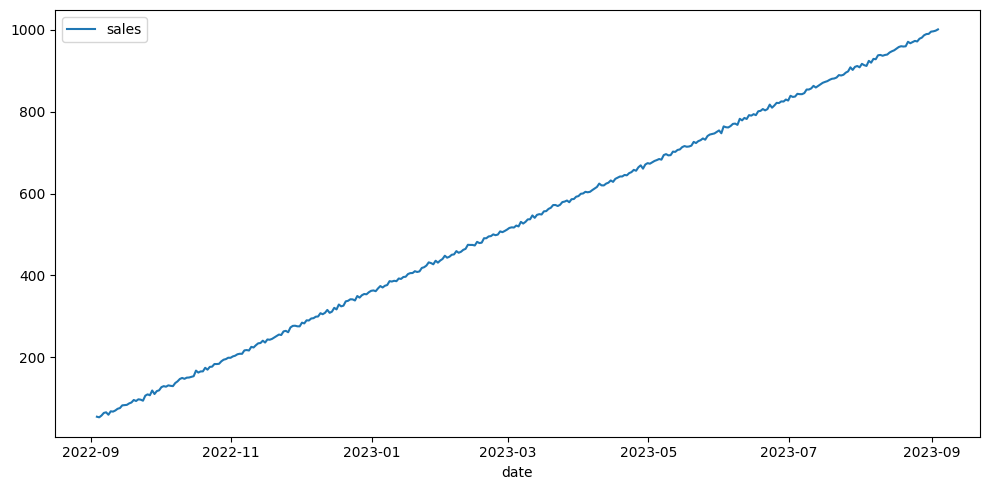

In [20]:
# Construcción y análisis de la serie temporal

import matplotlib.pyplot as plt
import seaborn as sns

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = total_data)

plt.tight_layout()

plt.show()

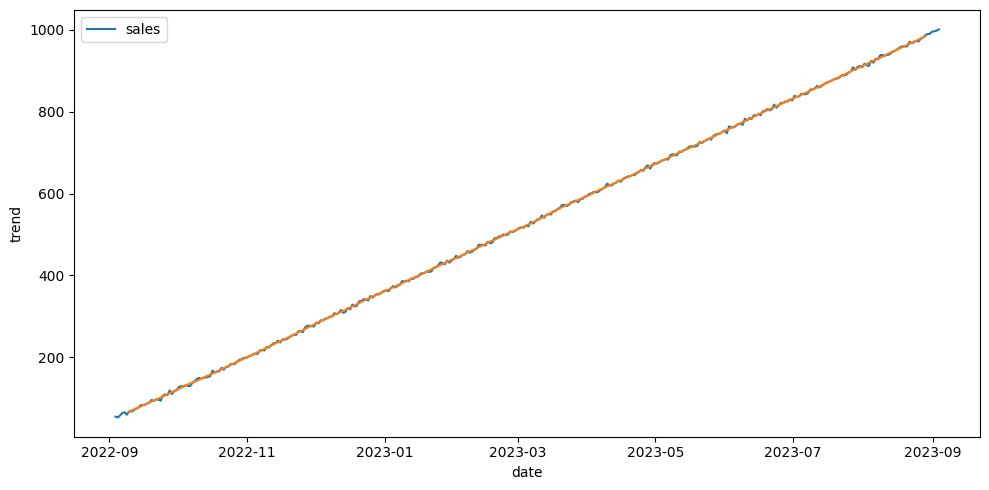

In [21]:
# Análisis de la serie temporal
# ¿Cuál es el tensor de la serie temporal? -> la unidad de tiempo mínima para la cuál hay datos son los segundos

# ¿Cuál es la tendencia? -> tendencia ascendente, es decir, las ventas han aumentado paulatinamente
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(total_data, period = 12)

trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = total_data)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

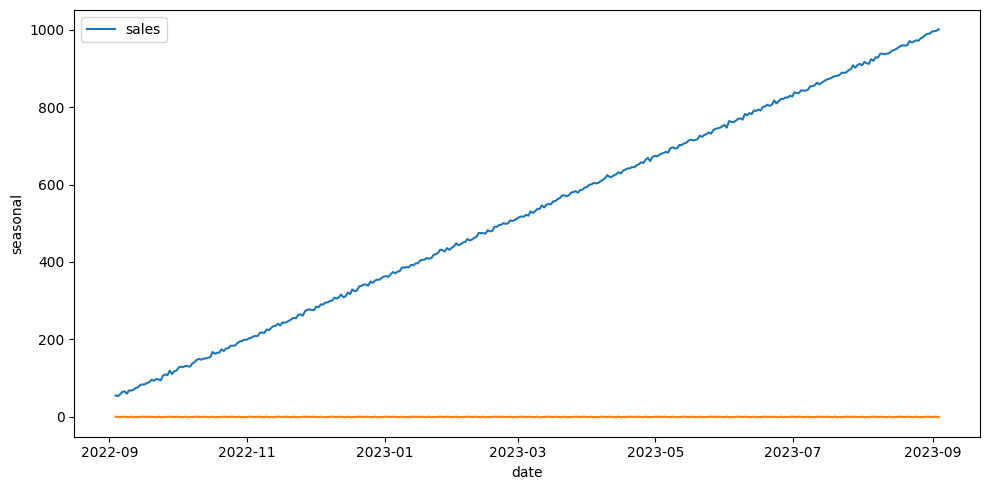

In [22]:
# ¿Es estacionaria? -> no tiene patrones repetitivos
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = total_data)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

In [23]:
# También se puede aplicar la Prueba de Dickey-Fuller
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(total_data)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

El valor de p es mayor que 0,05, por lo que se toma la serie como no estacionaria. Habría que transformarla para que se pueda aplicar el modelo ARIMA

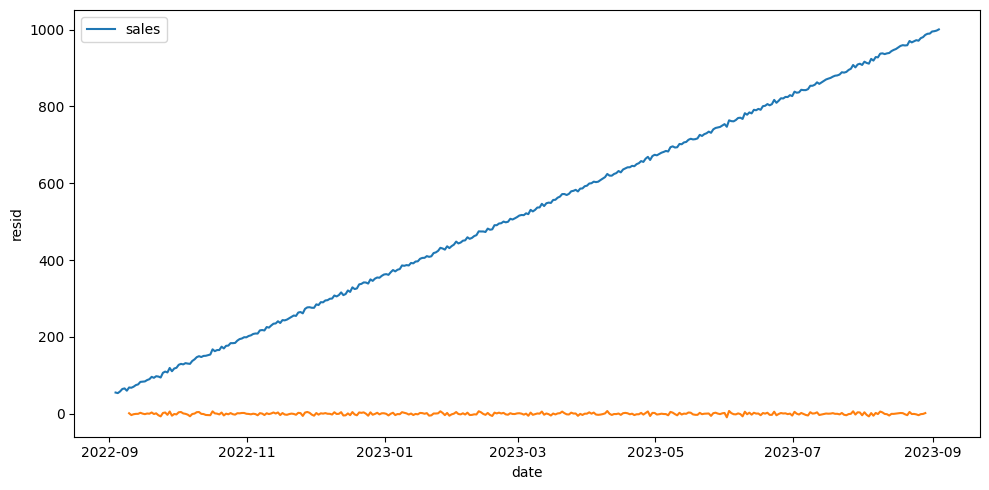

In [24]:
# Análisis de la variabilidad/residual
# ¿Existe variabilidad o presencia de ruido? 
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = total_data)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()

No se observan residuos o ruido.

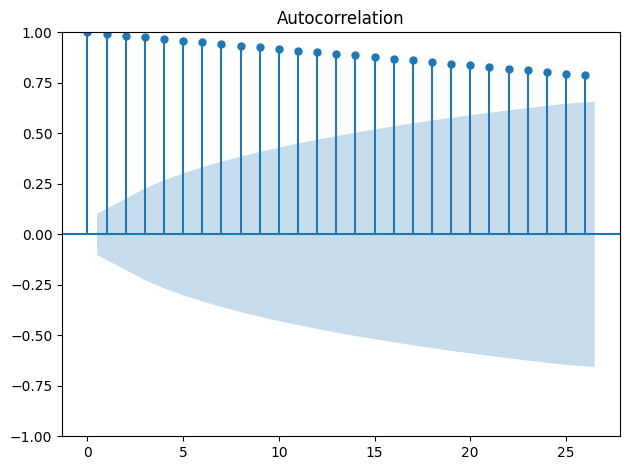

In [25]:
# Análisis de autocorrelación -> nos ayuda a ver si los valores en la serie de tiempo están correlacionados con los valores anteriores
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(total_data)

plt.tight_layout()

plt.show()

Existe una alta correlación entre los puntos.

In [26]:
# Entrenamiento del modelo -> modelo ARIMA
# Transformación en estacionaría para poder aplicar el modelo
total_data_stationary = total_data.diff().dropna()

test_stationarity(total_data_stationary)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

In [27]:
from pmdarima import auto_arima

model = auto_arima(total_data, seasonal = True, trace = True, m = 12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1847.125, Time=1.42 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2096.542, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1972.853, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2209.657, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=1844.660, Time=1.10 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1843.274, Time=0.48 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=1845.092, Time=1.20 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=1843.586, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=1841.532, Time=0.43 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=1843.436, Time=1.83 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=1843.433, Time=1.19 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.60 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1839.552, Time=0.25 sec
 ARIMA(1,1,1)(1,0,0)[12] inte

El mejor modelo ARIMA es es ARIMA(1,1,1)

In [28]:
# Información estadística y de rendimiento
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -915.776
Date:                Fri, 14 Jun 2024   AIC                           1839.552
Time:                        23:19:10   BIC                           1855.152
Sample:                    09-03-2022   HQIC                          1845.752
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8110      0.134     21.055      0.000       2.549       3.073
ar.L1         -0.0821      0.052     -1.592      0.111      -0.183       0.019
ma.L1         -0.9413      0.020    -47.701      0.000      -0.980      -0.903
sigma2         8.7903      0.688     12.777      0.000       7.442      10.139
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              1.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
# Predición
forecast = model.predict(100)
forecast

2023-09-04 17:10:08.079328    1002.158148
2023-09-05 17:10:08.079328    1004.831669
2023-09-06 17:10:08.079328    1007.423289
2023-09-07 17:10:08.079328    1010.021630
2023-09-08 17:10:08.079328    1012.619419
                                 ...     
2023-12-08 17:10:08.079328    1249.022047
2023-12-09 17:10:08.079328    1251.619878
2023-12-10 17:10:08.079328    1254.217709
2023-12-11 17:10:08.079328    1256.815540
2023-12-12 17:10:08.079328    1259.413371
Freq: D, Length: 100, dtype: float64

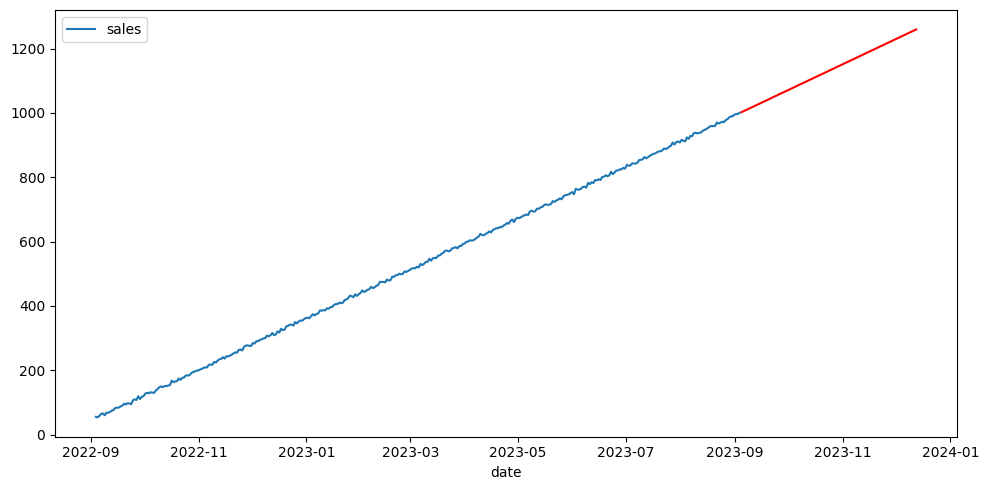

In [30]:
# Visualización de la predicción
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = total_data)
sns.lineplot(data = forecast, c = "red")

plt.tight_layout()

plt.show()

In [32]:
# Guardado del modelo
import pickle

with open('/workspaces/Series-temporales/models/temporal_serie_ARIMA.pkl', 'wb') as file:
    pickle.dump(model, file)